In [10]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors, ticker
import xarray as xr
from xgcm.grid import Grid
import xrft
from dask.diagnostics import ProgressBar
%matplotlib inline

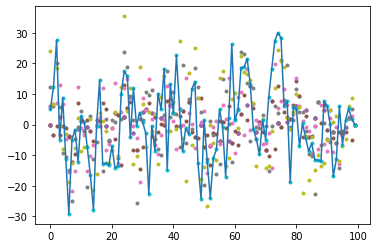

In [16]:
Lx = 100 # Length of field
z = np.zeros(Lx) # Initial topography array
z[:]=np.nan
N = np.sqrt(Lx).astype('int')
A = np.arange(N+1) # Define "amplitude function"
# Array for keeping track of filled points
pts = np.empty(Lx)
pts[:]=np.nan
# Define some initial starting points
pts_start = np.array([0,49,99])
# Assign random numbers to the initial starting points
i=0
for p in pts_start:
    z[int(p)] = A[0]*np.random.normal() # Random number assignment
    pts[int(p)]=int(p) # Keep track of the points that have been filled
    i+=1
    
### Main loop ###
for n in np.arange(N):
    # Isolate the points that have been filled
    pts_filled = pts[~np.isnan(pts)]
    # Define new points half way between the filled points
    pts_new = pts_filled[0:-1]+np.diff(pts_filled)/2
    # Calculate mean topography at new points and add a random number
    i=0
    for p in pts_new:
        pts_around = np.array([pts_filled[i],pts_filled[i+1]]).astype('int')
        mean = np.mean(z[pts_around])
        z[int(p)] = mean+A[n+1]*np.random.normal()
        pts[int(p)]=int(p)
        i+=1
    #print(np.isnan(pts))
    plt.plot(np.arange(0,Lx),z,'.')
plt.plot(z)

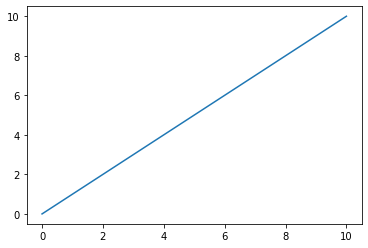

In [17]:
plt.plot(A)

In [18]:
Lx = 100 # Length of field
Ly = 100
z = np.zeros(shape=(Lx,Ly)) # Initial topography array
z[:]=np.nan
N = np.sqrt(np.max([Lx,Ly])).astype('int')
A = np.arange(N+1)-N
pts = np.empty(shape=(Lx,Ly))
pts[:]=np.nan
pts_index = np.empty(shape=(Lx,Ly),dtype=(float,2))
for i  in range(Lx):
    for j in range(Ly):
        pts_index[i,j]=(i,j)

pts_start_x = [0,49,99]
pts_start_y = [0,49,99]

for pi in pts_start_x:
    for pj in pts_start_y:
        z[int(pi),int(pj)]=A[0]*np.random.normal()
        pts[int(pi),int(pj)]=0

for n in range(N):
    pts_filled = pts_index[~np.isnan(pts)]
    pts_new = np.empty(shape=(len(pts_filled)-1,2))
    for i in range(len(pts_filled)-1):
        pi_1 = pts_filled[i,0].astype('int')
        pj_1 = pts_filled[i,1].astype('int')
        pi_2 = pts_filled[i+1,0].astype('int')
        pj_2 = pts_filled[i+1,1].astype('int')

        # NEED TO COME UP WITH A WAY OF DOING THIS COMPREHENSIVELY, CURRENTLY MISSES POINTS BECAUSE ONLY AVERAGES IN SEQUENCE
        pts_new = np.squeeze(pts_filled[i]+np.diff(pts_filled[i:i+2,:],axis=0)/2)
        pi = pts_new[0].astype('int')
        pj = pts_new[1].astype('int')

        z_around = np.array([z[pi_1,pj_1],z[pi_2,pj_2]])
        mean = np.mean(z_around)

        z[pi,pj] = mean+A[n+1]*np.random.normal()
        pts[pi,pj]=0

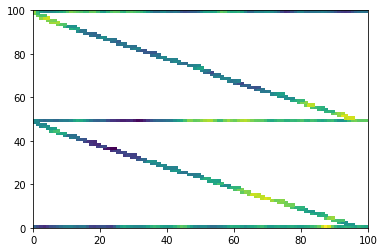

In [19]:
plt.pcolormesh(z)

In [38]:
Lx = 100 # Length of field
Ly = 100
z = np.zeros(shape=(Lx,Ly)) # Initial topography array
z[:]=np.nan
N = np.max([Lx,Ly]).astype('int')
A = -np.arange(N+1)+N
#A = 1+np.arange(N)
#A = 1/np.sqrt(A)

# Estimate A from topography scpectrum

In [4]:
# Read Topography Data (this is 5 km res close to southern ocean topography)
ds = xr.open_dataset('/Users/hemantkhatri/Dropbox/topog.socn.5km.nc')
grid = Grid(ds, periodic=['X'])
print(ds)
print(grid)

<xarray.Dataset>
Dimensions:  (xpa: 289, xpo: 4609, ypa: 91, ypo: 577)
Coordinates:
  * xpo      (xpo) float64 0.0 5.0 10.0 15.0 ... 2.303e+04 2.304e+04 2.304e+04
  * ypo      (ypo) float64 0.0 5.0 10.0 15.0 ... 2.87e+03 2.875e+03 2.88e+03
  * xpa      (xpa) float64 0.0 80.0 160.0 ... 2.288e+04 2.296e+04 2.304e+04
  * ypa      (ypa) float64 0.0 80.0 160.0 240.0 ... 7.04e+03 7.12e+03 7.2e+03
Data variables:
    dtopoc   (ypo, xpo) float64 ...
    dtopat   (ypa, xpa) float64 ...
<xgcm.Grid>


In [11]:
print(ds.ypo)

<xarray.DataArray 'ypo' (ypo: 577)>
array([   0.,    5.,   10., ..., 2870., 2875., 2880.])
Coordinates:
  * ypo      (ypo) float64 0.0 5.0 10.0 15.0 ... 2.87e+03 2.875e+03 2.88e+03
Attributes:
    units:    km


In [9]:
with ProgressBar():
    Topo_2D = xrft.power_spectrum(ds.dtopoc,dim=['xpo','ypo'], detrend='linear', window=True).compute()
    Topo_iso = xrft.isotropic_powerspectrum(ds.dtopoc,dim=['xpo','ypo'], detrend='linear', window=True).compute()

In [20]:
print(Topo_iso)

<xarray.DataArray (freq_r: 145)>
array([           nan, 1.68296730e+06, 1.39794434e+06, 1.27020620e+06,
       9.57482328e+05, 1.93972837e+06, 4.46236998e+05, 4.13718565e+05,
       6.88354272e+05, 4.71234018e+05, 2.99326003e+05, 2.14709636e+05,
       1.42516066e+05, 2.14529162e+05, 1.93116541e+05, 1.44331831e+05,
       1.07454297e+05, 7.08773310e+04, 7.13225934e+04, 9.23568913e+04,
       8.44481885e+04, 5.82647975e+04, 8.76311530e+04, 1.00121140e+05,
       6.21773417e+04, 7.26784959e+04, 9.23511354e+04, 6.70415268e+04,
       4.64591486e+04, 5.57719142e+04, 4.42438240e+04, 3.16885834e+04,
       3.51663663e+04, 3.09021458e+04, 2.72496723e+04, 3.49475864e+04,
       2.44706463e+04, 2.65484608e+04, 3.22753166e+04, 2.78035784e+04,
       1.95637791e+04, 2.23375309e+04, 2.47900314e+04, 1.94010890e+04,
       2.13800246e+04, 2.25014835e+04, 1.98532402e+04, 1.96823038e+04,
       2.01752555e+04, 2.22284973e+04, 1.65220070e+04, 1.62509839e+04,
       1.93434419e+04, 1.52184817e+04, 1.521

Text(0, 0.5, '[m$^3$ s$^{-2}$]')

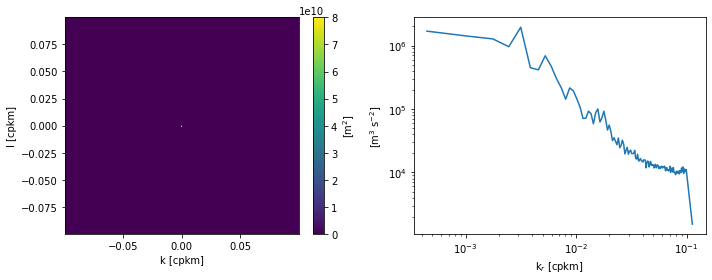

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.set_tight_layout(True)
im = axes[0].pcolormesh(Topo_2D.freq_xpo, Topo_2D.freq_ypo, Topo_2D)
axes[1].plot(Topo_iso.freq_r, Topo_iso)
cbar = fig.colorbar(im, ax=axes[0])
cbar.set_label(r'[m$^2$]')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[0].set_xlabel(r'k [cpkm]')
axes[0].set_ylabel(r'l [cpkm]')
axes[1].set_xlabel(r'k$_r$ [cpkm]')
axes[1].set_ylabel(r'[m$^3$ s$^{-2}$]')

In [49]:
B = Topo_iso.isel(freq_r=slice(1,101))
A = np.sqrt(B.load())*0.1
print(len(A))
print(A)

100
<xarray.DataArray (freq_r: 100)>
array([129.72922968, 118.23469625, 112.70342495,  97.85102596,
       139.27413133,  66.80097289,  64.32095807,  82.9671183 ,
        68.64648701,  54.71069395,  46.33677119,  37.75130016,
        46.31729288,  43.94502716,  37.99102929,  32.78022217,
        26.62279681,  26.70629015,  30.39027663,  29.05997048,
        24.13810214,  29.60255952,  31.64192473,  24.93538483,
        26.95894951,  30.3893296 ,  25.89237857,  21.55438439,
        23.61607804,  21.03421593,  17.80128743,  18.75269749,
        17.57900618,  16.50747476,  18.69427355,  15.64309633,
        16.29369841,  17.96533234,  16.67440505,  13.987058  ,
        14.94574552,  15.74485038,  13.9287792 ,  14.62190978,
        15.00049448,  14.09015266,  14.02936341,  14.20396266,
        14.90922442,  12.85379594,  12.74793471,  13.90807027,
        12.33632103,  12.33525119,  12.866395  ,  12.51737142,
        12.25211752,  12.05251516,  12.5746907 ,  12.52511136,
        12.4748964

In [50]:
Lx = 100 # Length of field
Ly = 100
z = np.zeros(shape=(Lx,Ly)) # Initial topography array
z[:]=np.nan
N = np.max([Lx,Ly]).astype('int')
#A = -np.arange(N+1)+N
#A = 1+np.arange(N)
#A = 1/np.sqrt(A)

pts = np.empty(shape=(Lx,Ly))
pts[:]=np.nan
pts_index = np.empty(shape=(Lx,Ly),dtype=(float,2))
for i  in range(Lx):
    for j in range(Ly):
        pts_index[i,j]=(i,j)

pts_start_x = [0,49,99]
pts_start_y = [0,49,99]

for pi in pts_start_x:
    for pj in pts_start_y:
        z[int(pi),int(pj)]=A[0]*np.random.normal()
        pts[int(pi),int(pj)]=0
        
for n in range(N):
    while np.where(np.isnan(pts[:]))[0].size>0:
        pts_last = np.array(pts[:])

        pts_filled = pts_index[~np.isnan(pts_last)]
        for i in range(len(pts_filled)-1):
            pi_old = pts_filled[i,0].astype('int')
            pj_old = pts_filled[i,1].astype('int')

            # Search for last and next filled point in each dimension
            # FIRST IN THE X-DIRECTION
            filled_above = ~np.isnan(pts_last[pi_old+1:,pj_old])
            filled_below = ~np.isnan(pts_last[:pi_old,pj_old])
            if np.where(filled_above)[0].size!=0: # Check that there is a filled point above/below
                # Find the index of the next filled point above the current point
                pi_above = np.min(np.where(filled_above))+pi_old+1
                # Get the mid-point between the current point and the point above
                pi = np.mean([pi_old,pi_above]).astype('int')
                if np.isnan(pts[pi,pj_old]): # Make the point hasn't already been filled
                    # Find the mean z between the current point and the point above
                    mean = np.mean(np.array([z[pi_old,pj_old],z[pi_above,pj_old]]))
                    # Add a random number
                    z[pi,pj_old]=mean+A[n+1]*np.random.normal()
                    # Mark that the point has been filled
                    pts[pi,pj_old]=0
            if np.where(filled_below)[0].size!=0:
                pi_below = np.max(np.where(filled_below))
                pi = np.mean([pi_below,pi_old]).astype('int')
                if np.isnan(pts[pi,pj_old]):
                    mean = np.mean(np.array([z[pi_below,pj_old],z[pi_old,pj_old]]))
                    z[pi,pj_old]=mean+A[n+1]*np.random.normal()
                    pts[pi,pj_old]=0
            # NOW IN THE Y-DIRECTION
            filled_above = ~np.isnan(pts_last[pi_old,pj_old+1:])
            filled_below = ~np.isnan(pts_last[pi_old,:pj_old])
            if np.where(filled_above)[0].size!=0:
                pj_above = np.min(np.where(filled_above))+pj_old+1
                pj = np.mean([pj_old,pj_above]).astype('int')
                if np.isnan(pts[pi_old,pj]):
                    mean = np.mean(np.array([z[pi_old,pj_old],z[pi_old,pj_above]]))
                    z[pi_old,pj]=mean+A[n+1]*np.random.normal()
                    pts[pi_old,pj]=0
            if np.where(filled_below)[0].size!=0:
                pj_below = np.max(np.where(filled_below))
                pj = np.mean([pj_below,pj_old]).astype('int')
                if np.isnan(pts[pi_old,pj]):
                    mean = np.mean(np.array([z[pi_old,pj_below],z[pj_old,pj_old]]))
                    z[pi_old,pj]=mean+A[n+1]*np.random.normal()
                    pts[pi_old,pj]=0

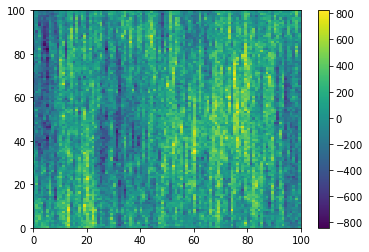

In [51]:
plt.pcolormesh(z)
plt.colorbar()

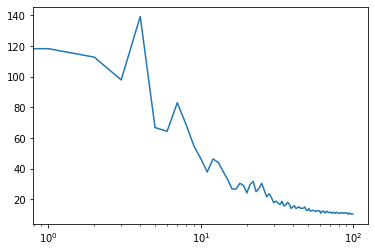

In [53]:
plt.semilogx(A)